# <font color="blue">Imports</font>

In [1]:
# Import des libraires
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as st
from sklearn.linear_model import LinearRegression  
import statsmodels.api as sm

In [2]:
# Import des fichiers
customers = pd.read_csv("Lapage/customers.csv",sep = ",") # customers
products = pd.read_csv("Lapage/products.csv", sep = ",") # products
transactions = pd.read_csv("Lapage/transactions.csv", sep = ",") # transactions

# <font color="blue"> Analyse exploratoire </font>

## Customers

In [3]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
# Ajout de l'âge
age = customers["birth"].apply(lambda x : 2022 - x)
customers.insert(loc=3, value = age, column = "age")

In [5]:
def desc(df) : 
    desc = df.describe(include = "all").transpose()
    types = df.dtypes
    types.name = "type"
    return desc.join(types)[["count", "unique", "mean", "type"]]

In [6]:
desc(customers) # pas d'anomalies constatées à ce stade

,count,unique,mean,type
client_id,8623,8623,NaN,object
sex,8623,2,NaN,object
birth,8623.0,NaN,1978.280877,int64
age,8623.0,NaN,43.719123,int64


## Products

In [7]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [8]:
desc(products) # pas d'anomalies constatées à ce stade

,count,unique,mean,type
id_prod,3287,3287,NaN,object
price,3287.0,NaN,21.856641,float64
categ,3287.0,NaN,0.370246,int64


In [9]:
products.categ.unique()

array([0, 1, 2])

<AxesSubplot:xlabel='price'>

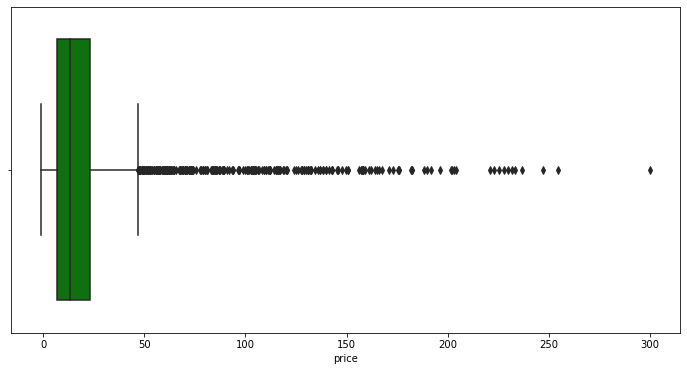

In [10]:
# Distribution des prix
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x = products.price, color = "green")

In [11]:
Q1, Q3 = np.percentile(products.price,(25,75))
IQ = st.stats.iqr(products.price)
upper_bound = Q3 + 1.5 * IQ

<AxesSubplot:ylabel='price'>

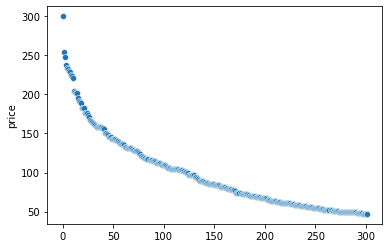

In [12]:
filtre = products.price > upper_bound
outliers = products[filtre]
outliers.sort_values("price",inplace = True,ascending = False)
outliers = outliers.reset_index()
sns.scatterplot(data = outliers , y = outliers.price, x = outliers.index)

In [13]:
# Placer les produits "suspects" dans une liste
produits_a_check = outliers[outliers.price > 200]

## Transactions

In [14]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [15]:
transactions.describe(include = "all")  # Investiguer session_id

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [16]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [17]:
# Liste des doublons de session_id
from iteration_utilities import duplicates
def listDups(listNums):
      return list(duplicates(listNums))

liste_doublons = listDups(transactions.session_id)

In [18]:
# Analyse d'un session_id en doublons
transactions[transactions.session_id.isin(["s_272055","s_290123"])]
# plusieurs achats effectué par un meme client durant une session de connexion au site auront la même session_id

,id_prod,date,session_id,client_id
334,0_1048,2022-09-22 22:48:39.419593,s_272055,c_5636
832,0_30,2022-09-22 22:49:05.168711,s_272055,c_5636
1611,0_865,2022-10-30 09:42:18.398394,s_290123,c_7716
3223,0_2216,2022-10-30 09:45:29.336713,s_290123,c_7716
49946,1_336,2022-09-22 23:02:33.108379,s_272055,c_5636
435564,0_1409,2022-09-22 22:08:58.176161,s_272055,c_5636
467029,0_1521,2022-10-30 09:55:11.009904,s_290123,c_7716


# <font color="blue"> Fusion des données </font>

In [19]:
#Fusion de customers avec transactions
customers_transactions = pd.merge(customers, transactions, how = "outer", indicator = True)

In [20]:
customers_transactions.pivot_table(index="_merge", values = "client_id", aggfunc = "count")
# pas de "right_only" : pour chaque transaction on a l'info client

,client_id
_merge,
left_only,21
right_only,0
both,679532


In [21]:
#on supprimme les "left_only" : clients sans transactions
customers_transactions = customers_transactions[customers_transactions._merge != "left_only"]
del customers_transactions["_merge"]

#Fusion de customers_transactions avec products
df = pd.merge(customers_transactions, products, how = "outer", indicator = True)

In [22]:
df.pivot_table(index="_merge", values = "id_prod", aggfunc = "count")
# 221 "left_only" : 221 transactions n'ont pas d'info produit

,id_prod
_merge,
left_only,221
right_only,21
both,679311


In [23]:
# on isole les transactions sans info produits
df_missing_prod = df[df._merge == "left_only"]
df_missing_prod.head(5)

,client_id,sex,birth,age,id_prod,date,session_id,price,categ,_merge
542051,c_4505,m,1976.0,46.0,0_2245,2022-01-09 09:23:31.000720,s_147220,NaN,NaN,left_only
542052,c_4505,m,1976.0,46.0,0_2245,2022-11-09 09:23:31.000720,s_295013,NaN,NaN,left_only
542053,c_3468,f,1981.0,41.0,0_2245,2021-09-11 10:52:05.205583,s_88251,NaN,NaN,left_only
542054,c_3468,f,1981.0,41.0,0_2245,2022-05-11 10:52:05.205583,s_206902,NaN,NaN,left_only
542055,c_1403,f,1978.0,44.0,0_2245,2022-09-15 14:26:50.187952,s_268455,NaN,NaN,left_only


In [24]:
df = df[df._merge == "both"]
del df["_merge"]

## <em> Imputation des prix pour les transactions sans info produits </em>

<AxesSubplot:xlabel='sex', ylabel='Proportion'>

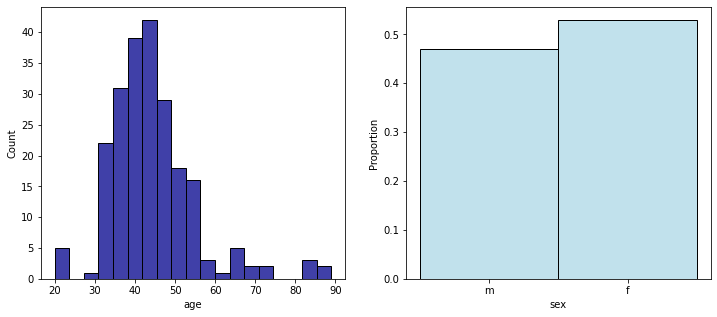

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize=(12,5))
sns.histplot(ax = ax[0],x = df_missing_prod.age, color = "darkblue")
sns.histplot(ax = ax[1],x = df_missing_prod.sex, stat = "proportion", color = "lightblue")

In [26]:
# découpage de l'age en tranche
def t_age(age):
    if age < 30 :
        return "inf 30"
    elif (age > 30 and age <= 40) :
        return "30-40"
    elif (age > 40 and age <= 50) :
        return "40-50"
    elif (age > 50 and age <= 60) :
        return "50-60"
    else :
        return "sup 60"
    
tranche_age = df["age"].apply(t_age)
df_calc = df[["age","sex","price","categ"]]
df_calc.insert(loc = 1, value = tranche_age, column = "tranche_age")

In [27]:
# calcul du prix moyen par tranche d'âge et par sexe
df_calc = df_calc.pivot_table(index = ["tranche_age", "sex"], values = "price", aggfunc = np.mean)
df_calc = df_calc.reset_index()
df_calc

,tranche_age,sex,price
0,30-40,f,13.259466
1,30-40,m,13.247619
2,40-50,f,13.238070
3,40-50,m,13.127110
4,50-60,f,16.753914
5,50-60,m,16.796138
6,inf 30,f,40.154894
7,inf 30,m,42.304842
8,sup 60,f,18.308050
9,sup 60,m,18.148948


In [28]:
# Affichage des prix moyen par catégorie
df.pivot_table(index="categ", values = "price", aggfunc = np.mean)

,price
categ,
0.0,10.632588
1.0,20.485730
2.0,76.207412


In [29]:
# Affectation d'une catégorie selon le prix
def categ(price) :
    if price < 15 :
        return 0.0
    elif price >= 15 and price < 30 :
        return 1.0
    else :
        return 2.0
    
df_calc["categ"] = df_calc["price"].apply(categ)
df_calc

,tranche_age,sex,price,categ
0,30-40,f,13.259466,0.0
1,30-40,m,13.247619,0.0
2,40-50,f,13.238070,0.0
3,40-50,m,13.127110,0.0
4,50-60,f,16.753914,1.0
5,50-60,m,16.796138,1.0
6,inf 30,f,40.154894,2.0
7,inf 30,m,42.304842,2.0
8,sup 60,f,18.308050,1.0
9,sup 60,m,18.148948,1.0


In [30]:
# Imputation des prix et categ aux manquants
tranche_age = df_missing_prod["age"].apply(t_age)
df_missing_prod.insert(loc = 4, value = tranche_age, column = "tranche_age")
del df_missing_prod["price"]
del df_missing_prod["categ"]
del df_missing_prod["_merge"]
df_missing_prod = pd.merge(df_missing_prod, df_calc, how = "left", on = ["tranche_age","sex"])
df_missing_prod

,client_id,sex,birth,age,tranche_age,id_prod,date,session_id,price,categ
0,c_4505,m,1976.0,46.0,40-50,0_2245,2022-01-09 09:23:31.000720,s_147220,13.12711,0.0
1,c_4505,m,1976.0,46.0,40-50,0_2245,2022-11-09 09:23:31.000720,s_295013,13.12711,0.0
2,c_3468,f,1981.0,41.0,40-50,0_2245,2021-09-11 10:52:05.205583,s_88251,13.23807,0.0
3,c_3468,f,1981.0,41.0,40-50,0_2245,2022-05-11 10:52:05.205583,s_206902,13.23807,0.0
4,c_1403,f,1978.0,44.0,40-50,0_2245,2022-09-15 14:26:50.187952,s_268455,13.23807,0.0
...,...,...,...,...,...,...,...,...,...,...
216,c_4283,f,1976.0,46.0,40-50,0_2245,2022-08-01 02:46:38.931757,s_246657,13.23807,0.0
217,c_4283,f,1976.0,46.0,40-50,0_2245,2021-09-01 02:46:38.931757,s_83377,13.23807,0.0
218,c_6236,f,1976.0,46.0,40-50,0_2245,2022-02-25 00:08:08.736068,s_170426,13.23807,0.0
219,c_4453,m,1981.0,41.0,40-50,0_2245,2022-02-16 11:35:20.319501,s_166050,13.12711,0.0


In [31]:
# on remet les lignes imputées dans le dataframe
del df_missing_prod["tranche_age"]
df = pd.concat([df, df_missing_prod])

In [32]:
# Conversion des dates au format date
def conv_date(date, fmt):
    try :
        return datetime.datetime.strptime(date[:10], '%Y-%m-%d').strftime(fmt)
    except :
        return None
    
    
date_mois = df.date.apply(conv_date, fmt = '%Y-%m')
date_jour = df.date.apply(conv_date, fmt = '%Y-%m-%d')
df.insert(loc = 6, value = date_mois, column = "date_mois")
df.insert(loc = 7, value = date_jour, column = "date_jour")
df[pd.isna(df.date_mois)]

,client_id,sex,birth,age,id_prod,date,date_mois,date_jour,session_id,price,categ
678109,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237419,None,None,s_0,-1.0,0.0
678110,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237425,None,None,s_0,-1.0,0.0
678111,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237436,None,None,s_0,-1.0,0.0
678112,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237430,None,None,s_0,-1.0,0.0
678113,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237449,None,None,s_0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
678304,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237420,None,None,s_0,-1.0,0.0
678305,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237427,None,None,s_0,-1.0,0.0
678306,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237449,None,None,s_0,-1.0,0.0
678307,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237424,None,None,s_0,-1.0,0.0


In [33]:
# Analyse des date en doublons

liste_doublons = listDups(df.date)

In [34]:
df_test = df[df.date.isin(["test_2021-03-01 02:30:02.237431","test_2021-03-01 02:30:02.237418", "test_2021-03-01 02:30:02.237424"])]
df_test
# ces lignes semblent correspondrent a des test et doivent etre supprimées car leur prix est incohérent

,client_id,sex,birth,age,id_prod,date,date_mois,date_jour,session_id,price,categ
678120,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237431,None,None,s_0,-1.0,0.0
678142,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237418,None,None,s_0,-1.0,0.0
678201,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237424,None,None,s_0,-1.0,0.0
678206,ct_0,f,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237424,None,None,s_0,-1.0,0.0
678218,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237418,None,None,s_0,-1.0,0.0
678244,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237424,None,None,s_0,-1.0,0.0
678261,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237418,None,None,s_0,-1.0,0.0
678262,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237431,None,None,s_0,-1.0,0.0
678271,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237424,None,None,s_0,-1.0,0.0
678276,ct_1,m,2001.0,21.0,T_0,test_2021-03-01 02:30:02.237431,None,None,s_0,-1.0,0.0


In [35]:
df = df[~df.date.str.contains("test")]

# <font color="blue"> Analyse du CA </font>

In [36]:
df.head(10)

,client_id,sex,birth,age,id_prod,date,date_mois,date_jour,session_id,price,categ
0,c_4410,f,1967.0,55.0,0_1316,2021-12-29 09:11:18.860592,2021-12,2021-12-29,s_141762,7.2,0.0
1,c_4410,f,1967.0,55.0,0_1316,2022-03-29 09:11:18.860592,2022-03,2022-03-29,s_186233,7.2,0.0
2,c_4410,f,1967.0,55.0,0_1316,2022-05-29 09:11:18.860592,2022-05,2022-05-29,s_215758,7.2,0.0
3,c_3654,f,1978.0,44.0,0_1316,2021-11-26 03:51:34.068872,2021-11,2021-11-26,s_125143,7.2,0.0
4,c_3654,f,1978.0,44.0,0_1316,2022-08-26 03:51:34.068872,2022-08,2022-08-26,s_258546,7.2,0.0
5,c_3991,f,1982.0,40.0,0_1316,2022-11-06 18:36:59.453434,2022-11,2022-11-06,s_293652,7.2,0.0
6,c_3991,f,1982.0,40.0,0_1316,2021-04-06 18:36:59.453434,2021-04,2021-04-06,s_16917,7.2,0.0
7,c_3991,f,1982.0,40.0,0_1316,2022-03-06 18:36:59.453434,2022-03,2022-03-06,s_175292,7.2,0.0
8,c_6071,f,1981.0,41.0,0_1316,2021-11-12 04:27:07.661417,2021-11,2021-11-12,s_118349,7.2,0.0
9,c_4430,m,1986.0,36.0,0_1316,2021-05-03 16:41:38.212848,2021-05,2021-05-03,s_29404,7.2,0.0


In [37]:
# calcul du CA par mois
CA_time = df.pivot_table(index=["date_mois"], values = "price", aggfunc = np.sum)
CA_time.columns = ["CA"]

In [38]:
# Indicateurs autour du CA
def indic(table,var):
    moyenne = round(table[var].mean(),2)
    medianne = round(np.percentile(table[var],50),2)
    ecart_type = round(table[var].std(ddof=0),2)
    coef_var = round(ecart_type / moyenne,2)
    Q1, Q3 = np.percentile(table[var],(25,75))
    IQ = round(Q3 - Q1,2)
    return pd.DataFrame(data = [moyenne, medianne, ecart_type, coef_var, IQ], index = ["Moyenne", "Mediane", "Ecart-type","Coefficient variation", "IQ"], columns = ["Indicateur"])

indic(CA_time, "CA")

,Indicateur
Moyenne,494040.42
Mediane,501702.73
Ecart-type,40344.39
Coefficient variation,0.08
IQ,31927.31


Text(0.5, 1.0, 'Distribution du CA mensuel')

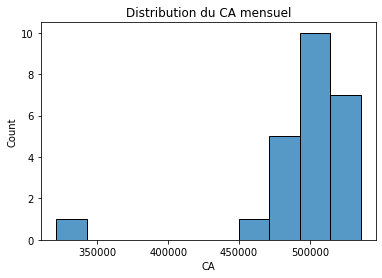

In [39]:
# Distribution du CA
g = sns.histplot(x = CA_time.CA)
g.set_title("Distribution du CA mensuel")

In [40]:
CA_date = df.pivot_table(index = "categ", columns = "date_mois", values = "price", aggfunc = "count", margins = True)
CA_date
# A 2021-10 On constate une rupture de tendance nette concernant le nb de ventes des produits de cat 1

date_mois,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,All
categ,,,,,,,,,,,,,,,,,,,,,
0.0,18138,19351,18507,15903,13581,15736,23153,18767,14607,19307,...,17277,17511,16655,17233,17672,17318,16940,17075,15262,415638
1.0,9136,7583,8109,9266,9170,7955,9269,1667,12318,12261,...,9791,9472,10308,9567,9728,9800,10064,10252,8789,227205
2.0,1336,1523,1677,1688,1991,1968,904,1172,1396,896,...,1443,1699,1589,1515,1574,1456,1621,1618,1501,36489
All,28610,28457,28293,26857,24742,25659,33326,21606,28321,32464,...,28511,28682,28552,28315,28974,28574,28625,28945,25552,679332


Text(0, 0.5, 'Nb de ventes')

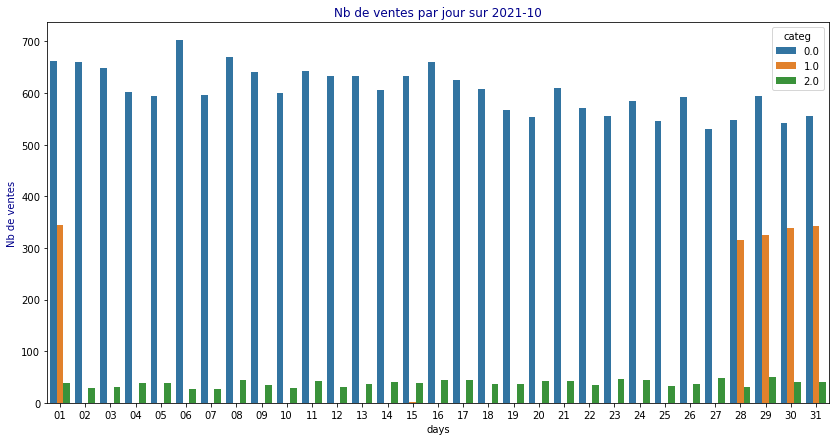

In [41]:
# On visualise le nb de ventes par jour selon catégorie de produits pour le mois d'octobre 2021
filtre = (df.date_mois == "2021-10")
df_oct = df[filtre]
df_oct.sort_values("date_jour",ascending = True, inplace = True)
days = df_oct.date_jour.apply(lambda x : x[-2:])
df_oct.insert(loc = 8, value = days, column = "days")
df_oct = df_oct.pivot_table(index = ["days", "categ"], values = "price", aggfunc = "count")
df_oct = df_oct.reset_index()
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.barplot(x = "days", y = "price", hue = "categ", data = df_oct)
ax.set_title("Nb de ventes par jour sur 2021-10", color = "darkblue")
ax.set_ylabel("Nb de ventes", color = "darkblue")

In [42]:
# On choisit de supprimer totalement le mois d'octobre qui parait en anomalie pour les produits de cat 1
filtre = (df.date_mois == "2021-10")
df = df[~filtre]
CA_time = df.pivot_table(index=["date_mois"], values = "price", aggfunc = np.sum)
CA_time.columns = ["CA"]

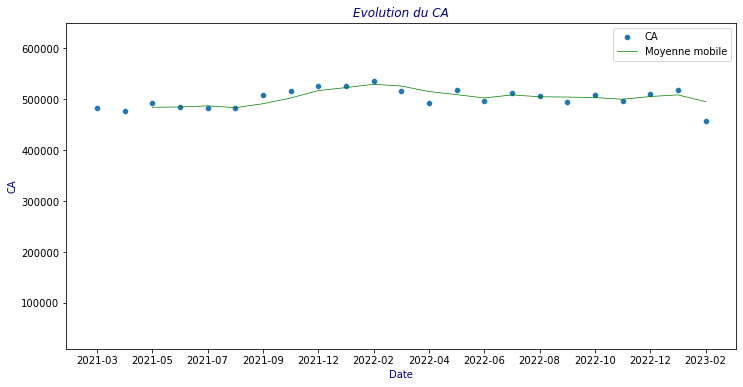

In [43]:
# Graph évolution du CA
x = CA_time.index
x = list(x)
ticks = []
for i in range(0,len(x),2) :
    ticks.append(x[i])

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.scatterplot(data = CA_time, x = CA_time.index, y="CA")
ax.set_xticks(ticks)
ax.set_ylim(10000, 650000)
ax.set_title("Evolution du CA", fontweight = 520, color = "darkblue", fontstyle = "italic")
ax.set_xlabel("Date", color = "darkblue")
ax.set_ylabel("CA", color = "darkblue")

# Ajout moyenne mobile
av_mean = CA_time.rolling(3).mean()
av_mean = av_mean[2:]
ax.plot(av_mean.index, av_mean.values, color = "green", lw = 0.7)
ax.legend(["CA","Moyenne mobile"], loc = 'best')

## Top/Flop produits

In [44]:
# calcul du CA par produits
CA_prod = df.pivot_table(index = ["id_prod","categ"], values = "price", aggfunc = (np.sum, "count"))
Top = CA_prod.sort_values("count",ascending = False)
Top.head(10)

,,count,sum
id_prod,categ,,
1_369,1.0,2237,53665.63
1_417,1.0,2173,45611.27
1_414,1.0,2166,51615.78
1_498,1.0,2117,49474.29
1_425,1.0,2084,35407.16
1_403,1.0,1950,35080.50
1_412,1.0,1938,32267.70
1_406,1.0,1931,47908.11
1_413,1.0,1931,34738.69


In [45]:
Flop = CA_prod.sort_values("count",ascending = True)
Flop.head(18)

,,count,sum
id_prod,categ,,
0_1151,0.0,1,2.99
0_1284,0.0,1,1.38
2_98,2.0,1,149.74
0_1683,0.0,1,2.99
0_898,0.0,1,1.27
0_541,0.0,1,1.99
0_549,0.0,1,2.99
0_1601,0.0,1,1.99
0_807,0.0,1,1.99


## Focus Catégorie

In [46]:
# calcul du CA par catégorie
CA_categ = df.pivot_table(index = "categ", values = "price", aggfunc = (np.sum, "count", np.mean))
CA_categ["Prix moyen"] = CA_categ["mean"].apply(lambda x : round(x,2))
del CA_categ["mean"]
CA_categ.columns = ["Nb ventes", "CA", "Prix moyen"]
CA_categ[["Prix moyen"]]

,Prix moyen
categ,
0.0,10.64
1.0,20.49
2.0,76.24


Text(0.5, 1.0, 'Ventes par catégorie')

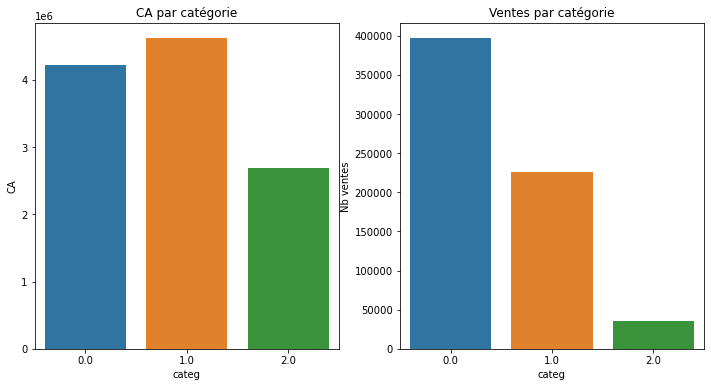

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.barplot(ax =ax[0], x = CA_categ.index, y = "CA", data = CA_categ)
ax[0].set_title("CA par catégorie")
sns.barplot(ax =ax[1], x = CA_categ.index, y = "Nb ventes", data = CA_categ)
ax[1].set_title("Ventes par catégorie")

## Focus Panier

In [48]:
# calcul du CA par panier
CA_panier = df.pivot_table(index = ["session_id", "client_id", "age", "sex"], values = "price", aggfunc = (np.sum, "count"))
CA_panier.sort_values("sum",ascending = True, inplace = True)
CA_panier.columns = ["Ventes", "CA"]
CA_panier = CA_panier.reset_index()
CA_panier

,session_id,client_id,age,sex,Ventes,CA
0,s_41352,c_3757,63.0,f,1,0.62
1,s_260416,c_3757,63.0,f,1,0.62
2,s_34456,c_5510,81.0,f,1,0.62
3,s_83637,c_5969,57.0,m,1,0.66
4,s_246917,c_5969,57.0,m,1,0.66
...,...,...,...,...,...,...
330764,s_150439,c_667,29.0,m,4,496.22
330765,s_335005,c_3241,18.0,f,3,535.17
330766,s_83158,c_3241,18.0,f,3,535.17
330767,s_123227,c_8345,29.0,f,3,539.23


## Focus Clients

In [49]:
# calcul du CA par clients
CA_clients = df.pivot_table(index = ["client_id", "age", "sex"], values = "price", aggfunc = (np.sum, "count"))
CA_clients.sort_values("sum",ascending = True, inplace = True)
CA_clients.columns = ["Ventes", "CA"]
CA_clients = CA_clients.reset_index()
CA_clients

,client_id,age,sex,Ventes,CA
0,c_8140,51.0,m,2,8.300000
1,c_8114,60.0,m,2,9.980000
2,c_240,24.0,m,1,11.060000
3,c_4648,18.0,m,1,11.200000
4,c_2793,89.0,m,1,12.990000
...,...,...,...,...,...
8593,c_2899,28.0,f,105,5214.050000
8594,c_3454,53.0,m,6635,111817.098413
8595,c_6714,54.0,f,8903,149884.273482
8596,c_4958,23.0,m,5090,282654.610000


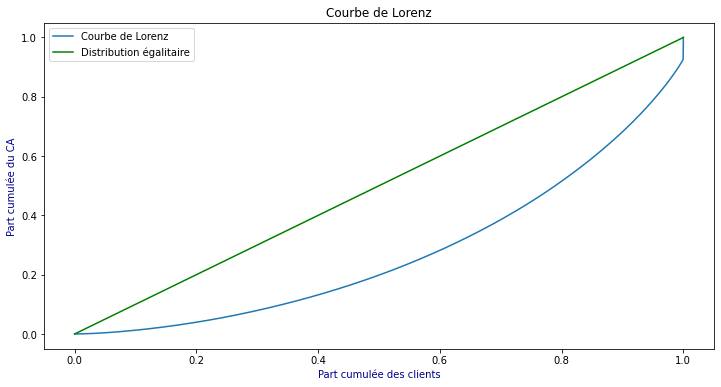

In [50]:
# Courbe de Lorenz
fig, ax = plt.subplots(figsize=(12,6))
data = CA_clients
y = np.cumsum(data.CA) / np.sum(data.CA)
y = np.append(0,y)
x = np.linspace(0,1,len(y))
plt.plot(x, y)
plt.plot(x, x, color = "green")
ax.set_title("Courbe de Lorenz")
ax.set_xlabel("Part cumulée des clients", color = "darkblue")
ax.set_ylabel("Part cumulée du CA", color = "darkblue")
ax.legend(["Courbe de Lorenz","Distribution égalitaire"], loc = 'best')


In [51]:
CA_moyen = CA_clients[CA_clients.client_id != "c_1609"].CA.mean()
CA_client = CA_clients[CA_clients.client_id == "c_1609"].CA.values[0]
Quantite_moyen = CA_clients[CA_clients.client_id != "c_1609"].Ventes.mean()
Quantite_client = CA_clients[CA_clients.client_id == "c_1609"].Ventes.values[0]
Panier_moyen = CA_panier[CA_panier.client_id != "c_1609"].CA.mean()
Panier_client = CA_panier[CA_panier.client_id == "c_1609"].CA.mean()
Age_moyen = CA_clients[CA_clients.client_id != "c_1609"].age.mean()
Age_client = CA_clients[CA_clients.client_id == "c_1609"].age.values[0]

In [52]:
pd.DataFrame(index = ["Top client", "Moyenne Pop"], columns = ["age","Panier", "Quantité", "CA"],
             data = [[round(Age_client,0), round(Panier_client,2), round(Quantite_client,0), round(CA_client,2)], [round(Age_moyen,0), round(Panier_moyen,2), round(Quantite_moyen,0), round(CA_moyen,0)]])

,age,Panier,Quantité,CA
Top client,42.0,29.68,24472.0,312755.08
Moyenne Pop,44.0,35.05,74.0,1305.00


In [53]:
# CA_client sans outliers
Q1, Q3 = np.percentile(CA_clients.CA,(25,75))
IQ = Q3 - Q1
upper_bound = Q3 + (1.5 * IQ)
lower_bound = Q1 - (1.5 * IQ)
filtre = (CA_clients.CA <= upper_bound) & (CA_clients.CA >= lower_bound)
CA_clients_sans_outliers = CA_clients[filtre]

# <font color="blue"> Corrélations </font>

## Genre clients et Catégories de livres

In [54]:
df.head(5)

,client_id,sex,birth,age,id_prod,date,date_mois,date_jour,session_id,price,categ
0,c_4410,f,1967.0,55.0,0_1316,2021-12-29 09:11:18.860592,2021-12,2021-12-29,s_141762,7.2,0.0
1,c_4410,f,1967.0,55.0,0_1316,2022-03-29 09:11:18.860592,2022-03,2022-03-29,s_186233,7.2,0.0
2,c_4410,f,1967.0,55.0,0_1316,2022-05-29 09:11:18.860592,2022-05,2022-05-29,s_215758,7.2,0.0
3,c_3654,f,1978.0,44.0,0_1316,2021-11-26 03:51:34.068872,2021-11,2021-11-26,s_125143,7.2,0.0
4,c_3654,f,1978.0,44.0,0_1316,2022-08-26 03:51:34.068872,2022-08,2022-08-26,s_258546,7.2,0.0


<AxesSubplot:xlabel='sex', ylabel='pct_client'>

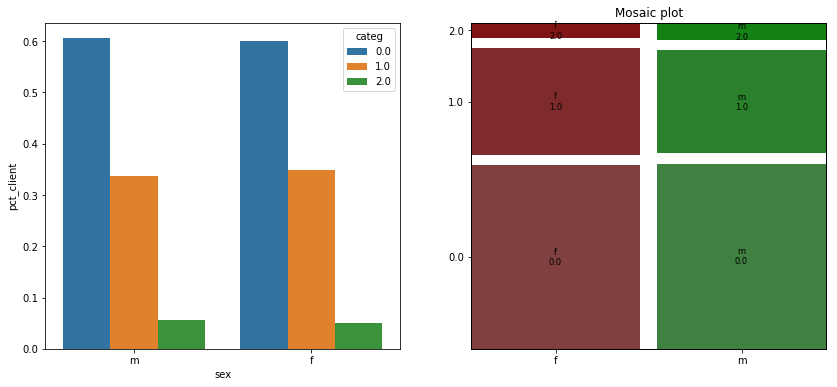

In [55]:
# Barplot et Mosaic plot
tab = df[["client_id", "sex", "categ"]].pivot_table(index = ["sex", "categ"], aggfunc = "count")
tab = tab.reset_index()
tab_f = tab[tab.sex == "f"]
tab_h = tab[tab.sex == "m"]
tab_f["pct_client"] = tab_f.client_id / tab_f.client_id.sum()
tab_h["pct_client"] = tab_h.client_id / tab_h.client_id.sum()
tab = pd.concat([tab_h, tab_f])
from statsmodels.graphics.mosaicplot import mosaic
df_mosaic = df[["sex","categ"]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
mosaic(ax = ax[1], data = df_mosaic, index = ["sex", "categ"], title='Mosaic plot', gap = 0.05)
sns.barplot(ax = ax[0], x = "sex",y = "pct_client", hue = "categ", data=tab)

In [56]:
# Tableau de contingence entre sexe et catégorie
tab = pd.crosstab(df['sex'], df['categ'])
table = sm.stats.Table(tab)
table.table_orig

categ,0.0,1.0,2.0
sex,,,
f,197074,114109,16724
m,199797,111429,18593


In [57]:
# Tableau dans d'une distribution indépendante
table.fittedvalues

categ,0.0,1.0,2.0
sex,,,
f,197858.650862,112441.182143,17607.166995
m,199012.349138,113096.817857,17709.833005


In [58]:
# Test du khi2 d'indépendance
res = table.test_nominal_association()
res.pvalue #On rejette l'hypothèse d'une indépendance du sexe sur la catégorie de livre acheté

0.0

In [59]:
# Test du khi2 d'indépendance : autre méthode
st_chi2, st_p, st_dof, st_exp = st.stats.chi2_contingency(tab)
st_p

5.711650295264503e-32

In [100]:
# V de Cramer
array = np.array(tab)
n = np.sum(array)
minDim = min(array.shape)-1
V = np.sqrt((st_chi2/n) / minDim)
V

0.014790346839867298

## Age clients et CA

In [60]:
CA_clients_sans_outliers

,client_id,age,sex,Ventes,CA
0,c_8140,51.0,m,2,8.30
1,c_8114,60.0,m,2,9.98
2,c_240,24.0,m,1,11.06
3,c_4648,18.0,m,1,11.20
4,c_2793,89.0,m,1,12.99
...,...,...,...,...,...
8345,c_1252,47.0,m,282,3504.70
8346,c_8157,29.0,m,77,3505.28
8347,c_5545,40.0,f,293,3505.47
8348,c_7383,41.0,f,264,3516.25


In [61]:
age_CA = CA_clients_sans_outliers.pivot_table(index = "age", values= "CA", aggfunc = (np.mean, "count"))
age_CA = age_CA.reset_index()
age_CA.columns = ["age", "nb", "CA"]

Text(0, 0.5, 'CA')

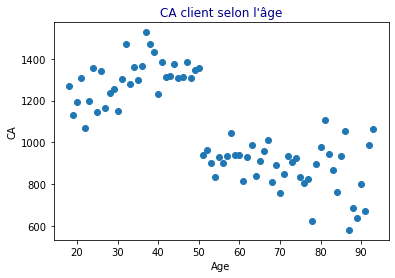

In [62]:
# Nuage de point CA, âge
plt.scatter(age_CA.age, age_CA.CA)
plt.title("CA client selon l'âge", color = "darkblue")
plt.xlabel("Age")
plt.ylabel("CA")

In [63]:
# Coefficient de corrélation CA, âge
coef, p_value = st.stats.pearsonr(age_CA.age, age_CA.CA)
print (coef, p_value) #on rejette l'hypothèse de non corrélation

-0.7580467903543224 2.21928883151444e-15


In [86]:
age_vente_av50 = age_CA[age_CA.age <= 50]
age_vente_ap50 = age_CA[age_CA.age > 50]

In [89]:
# Coefficient de corrélation CA, âge
coef, p_value = st.stats.pearsonr(age_vente_av50.age, age_vente_av50.CA)
print (coef, p_value) #on rejette l'hypothèse de non corrélation

0.5265505111632217 0.001644682874028004


In [90]:
# Coefficient de corrélation CA, âge
coef, p_value = st.stats.pearsonr(age_vente_ap50.age, age_vente_ap50.CA)
print (coef, p_value) #on rejette l'hypothèse de non corrélation

-0.2784804917440453 0.07056508672379197


## Age clients et Nb de ventes

In [64]:
nb_session = CA_panier.pivot_table(index = "client_id", values= "session_id", aggfunc = "count")
nb_session = nb_session.reset_index()
nb_session.columns = ["client_id", "nb_session"]

In [65]:
CA_clients_nb_session = pd.merge(CA_clients_sans_outliers,nb_session, how = "left")

In [66]:
age_vente = CA_clients_nb_session.pivot_table(index = "age", values= "nb_session", aggfunc = (np.mean, "count"))
age_vente = age_vente.reset_index()
age_vente.columns = ["age", "nb", "ventes"]

Text(0, 0.5, 'Nb sessions')

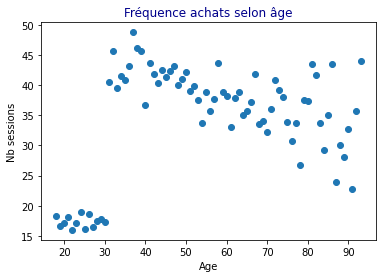

In [67]:
# Nuage de point ventes, âge
plt.scatter(age_vente.age, age_vente.ventes)
plt.title("Fréquence achats selon âge", color = "darkblue")
plt.xlabel("Age")
plt.ylabel("Nb sessions")

In [68]:
# Coefficient de corrélation CA, âge
coef, p_value = st.stats.pearsonr(age_vente.age, age_vente.ventes)
print (coef, p_value) #on rejette l'hypothèse de non corrélation linéaire

0.30610734940340295 0.007161540189620991


In [69]:
age_vente_av30 = age_vente[age_vente.age <= 30]
age_vente_ap30 = age_vente[age_vente.age > 30]

In [70]:
# Coefficient de corrélation CA, âge pour age <= 30
coef, p_value = st.stats.pearsonr(age_vente_av30.age, age_vente_av30.ventes)
print (coef, p_value) #on ne rejette pas l'hypothèse de non corrélation linéaire

-9.864516633851725e-05 0.9997448148828542


In [71]:
# Coefficient de corrélation CA, âge pour age > 30
coef, p_value = st.stats.pearsonr(age_vente_ap30.age, age_vente_ap30.ventes)
print (coef, p_value) #on rejette l'hypothèse de non corrélation linéaire

-0.6170198841477824 7.232723575493826e-08


## Age clients et taille du panier

In [72]:
age_panier = CA_panier.pivot_table(index = "age", values= "CA", aggfunc = (np.mean, "count"))
age_panier = age_panier.reset_index()
age_panier.columns = ["age", "nb", "CA_panier"]
age_panier

,age,nb,CA_panier
0,18.0,8341,70.904475
1,19.0,2484,69.577999
2,20.0,2527,70.793077
3,21.0,2371,73.533387
4,22.0,2358,68.123630
...,...,...,...
71,89.0,224,22.755040
72,90.0,196,24.508367
73,91.0,91,29.573516
74,92.0,143,27.686993


Text(0, 0.5, 'Taille du panier')

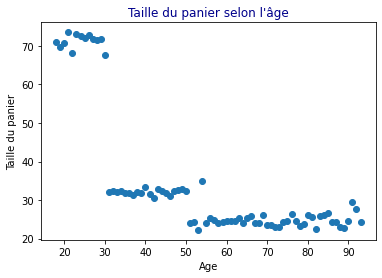

In [73]:
# Nuage de point taille panier, âge
plt.scatter(age_panier.age, age_panier.CA_panier)
plt.title("Taille du panier selon l'âge", color = "darkblue")
plt.xlabel("Age")
plt.ylabel("Taille du panier")

In [74]:
# Coefficient de corrélation CA, âge
coef, p_value = st.stats.pearsonr(age_panier.age, age_panier.CA_panier)
print (coef, p_value) #on rejette l'hypothèse de non corrélation

-0.7473934785978524 8.847198275500821e-15


In [75]:
age_panier_30 = age_panier[age_panier.age <= 30]
age_panier_30_50 = age_panier[(age_panier.age > 30) & (age_panier.age < 50)]
age_panier_50 = age_panier[age_panier.age > 50]

In [76]:
# Coefficient de corrélation CA, âge avt 30
coef, p_value = st.stats.pearsonr(age_panier_30.age, age_panier_30.CA_panier)
print (coef, p_value) #on ne rejette pas l'hypothèse de non corrélation

-0.04534385475870731 0.883060994260949


In [77]:
# Coefficient de corrélation CA, âge 30-50
coef, p_value = st.stats.pearsonr(age_panier_30_50.age, age_panier_30_50.CA_panier)
print (coef, p_value) #on ne rejette pas l'hypothèse de non corrélation

0.06907907797045093 0.7787087062357672


In [78]:
# Coefficient de corrélation CA, âge apres 30
coef, p_value = st.stats.pearsonr(age_panier_50.age, age_panier_50.CA_panier)
print (coef, p_value) #on ne rejette pas l'hypothèse de non corrélation

0.0028304770406023215 0.9856278700305763


## Age clients et catégorie de livres achetés

In [79]:
df_pivot = df.pivot_table(index = ["age", "categ"], values= "client_id", aggfunc = "count")
df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.pivot("age", "categ", "client_id")
df_pivot

categ,0.0,1.0,2.0
age,,,
18.0,3283,5671,5815
19.0,850,1662,1726
20.0,967,1716,1785
21.0,941,1544,1676
22.0,1051,1616,1632
...,...,...,...
89.0,136,178,1
90.0,116,175,2
91.0,73,89,2


<AxesSubplot:xlabel='categ', ylabel='age'>

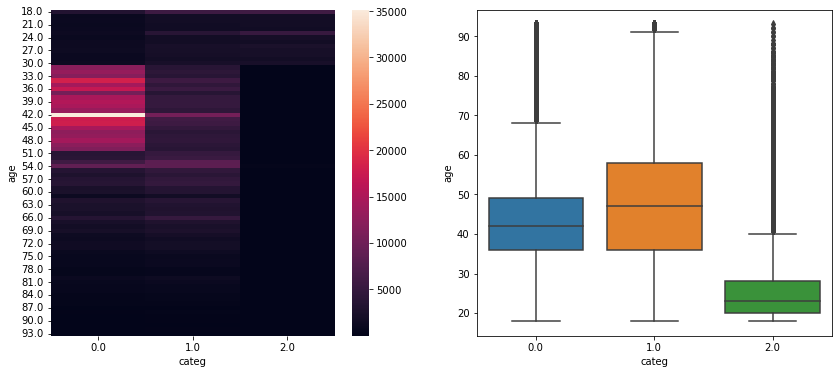

In [80]:
# Graphs âge selon catégorie
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.heatmap(ax = ax[0], data = df_pivot)
sns.boxplot(ax = ax[1], x='categ', y='age', data=df)

In [81]:
# Test ANOVA
age_0 = df[df.categ == 0.0].age
age_1 = df[df.categ == 1.0].age
age_2 = df[df.categ == 2.0].age
fvalue, pvalue = st.stats.f_oneway(age_0, age_1, age_2)
pvalue 

0.0

In [82]:
# Verification de l'homogéénité des variances
from scipy.stats import bartlett
bartlett(age_0, age_1, age_2) # On rejette l'homogéénité des variances

BartlettResult(statistic=35849.96466155407, pvalue=0.0)

In [83]:
# Vérification de distribution normale de chaque groupe
from scipy.stats import shapiro
sampled_age_0 = age_0.sample(n=1000, random_state=1000)
sampled_age_1 = age_1.sample(n=1000, random_state=1000)
sampled_age_2 = age_2.sample(n=1000, random_state=1000)
print(shapiro(sampled_age_0)[1], shapiro(sampled_age_1)[1], shapiro(sampled_age_2)[1])
# On rejette la normalité des distributions dans chaque groupe

1.2869612012223854e-19 1.2932664716913678e-08 2.1406235341025906e-40


In [84]:
# Vérification de distribution normale des résidus
from statsmodels.formula.api import ols
from scipy.stats import shapiro
sampled_df = df.sample(n=1000, random_state=1000)
model = ols('age ~ categ', data=sampled_df).fit()
shapiro(model.resid)   # On rejette la normalité des résidus

ShapiroResult(statistic=0.9609363079071045, pvalue=1.0519151823603018e-15)

In [85]:
# On utilise un test de krukal wallis car non validation des hypothèses sur ANOVA 
kruskal = st.stats.kruskal(age_0, age_1, age_2)
p_value = kruskal[1]
p_value # On rejette l'hypothèse d'une indépendance de l'âge sur la catégorie de livre acheté

0.0